<a href="https://colab.research.google.com/github/k1151msarandega/QuCode-21-Days-of-Quantum-Challenge-Diary/blob/main/Day10_Quantum_Superposition_%26_Interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 10 — Quantum Superposition & Interference

> _QuCode 21 Days of Quantum Challenge — Learning notebook_
>
> **Date:** 2025-09-10  
> **Author:** Kudzai Musarandega  
> **Tags:** quantum, learning, challenge, day-10
> **Focus:** quantum parallelism, phase kickback, and how interference extracts global information
>
> **Learning objectives**
> - **Explain** how relative phase drives single-qubit interference and derive $$P(0)=\cos^2(\phi/2).$$  
> - **Demonstrate** visibility loss by inserting a controlled-$$U$$ and relate it to $$V=|\langle 0|U|0\rangle|.$$  
> - **Construct** a black-box oracle $$U_f$$ and show **quantum parallelism** with a data superposition.  
> - **Use** $$|-\rangle$$ targets to achieve **phase kickback** and recover global properties via interference.  
> - **Implement** (and test) the **Deutsch algorithm** as the minimal example of “parallelism + interference.”
>
> **Key takeaways (summary-first)**
> - **Superposition** allows storing many computational branches at once; **measurement** returns one branch.  
> - **Interference** is how quantum algorithms amplify the right answers and cancel the wrong ones.  
> - **Phase kickback** converts function values into phases, which **interfere** to reveal global properties.  
> - **Entanglement with an environment (or ancilla)** leaks which-path information and **reduces visibility**.  
> - Practical algorithms (Deutsch–Jozsa, Simon, Grover, QFT-based) = **parallelism + interference**.

## Resources
- **Official/Assigned:**
    - [THE QUANTUM SCIENTIST: Quantum Parallelism | Quantum computing](https://www.youtube.com/watch?v=zUL7EzZ328A)
    - [Artur Ekert: Entanglement, interference, and visibility](https://www.youtube.com/watch?v=ot2BAKigS1E)
- **Extra reading:**

- **Original notes:**

In [ ]:
# %% [markdown]
# ### Environment setup (Colab)
# If you are running on Colab for the first time today, uncomment to install.
# This cell intentionally avoids heavy installs by default.
#
# !pip -q install qiskit pennylane matplotlib numpy

import sys, platform, math, json, numpy as np

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
np.random.seed(42)


## 1) Concepts in brief

- **Superposition:** a qubit $$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$ with $$|\alpha|^2+|\beta|^2=1.$$
- **Interference:** amplitudes add with phases; measurement probabilities depend on relative phases.
- **H–Phase–H interferometer:** $$|0\rangle \xrightarrow{H} \tfrac{|0\rangle+|1\rangle}{\sqrt2} \xrightarrow{R_z(\phi)} \tfrac{|0\rangle+e^{i\phi}|1\rangle}{\sqrt2} \xrightarrow{H} \cdots$$  
  leads to $$P(0)=\cos^2\!\frac{\phi}{2},\quad P(1)=\sin^2\!\frac{\phi}{2}.$$
- **Quantum parallelism:** with an oracle $$U_f:\ |x\rangle|y\rangle \mapsto |x\rangle|y\oplus f(x)\rangle,$$ preparing a superposition $$\frac{1}{\sqrt{2^n}}\sum_x|x\rangle$$ evaluates **all** inputs at once in the state.  
  Measurement alone yields one sample; **interference** (e.g., phase kickback) extracts global properties.
- **Phase kickback:** using $$|-\rangle=\tfrac{|0\rangle-|1\rangle}{\sqrt2}$$ as the target gives  
  $$U_f\big(|x\rangle|-\rangle\big)=(-1)^{f(x)}|x\rangle|-\rangle,$$ imprinting $$f(x)$$ as a phase on the control.
- **Which-path info kills interference:** entangling the “paths” with an ancilla reduces visibility  
  $$P(0)=\tfrac12\big(1+ V\cos(\phi+\alpha)\big),\quad V=|\langle 0|U|0\rangle|\le 1.$$

In [1]:
# 2) Setup: NumPy gates & helpers
import numpy as np
import itertools
import matplotlib.pyplot as plt

def integrate(y, x):
    # Numpy 2.0 deprecates trapz alias; prefer trapezoid if present.
    if hasattr(np, 'trapezoid'):
        return np.trapezoid(y, x)
    return np.trapz(y, x)

# Single-qubit basis and gates
I2 = np.eye(2, dtype=complex)
X  = np.array([[0,1],[1,0]], dtype=complex)
Y  = np.array([[0,-1j],[1j,0]], dtype=complex)
Z  = np.array([[1,0],[0,-1]], dtype=complex)
H  = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)

def Rz(phi):
    return np.array([[1,0],[0,np.exp(1j*phi)]], dtype=complex)

def Rx(theta):
    c, s = np.cos(theta/2), -1j*np.sin(theta/2)
    return np.array([[c, s],[s, c]], dtype=complex)

def Ry(theta):
    c, s = np.cos(theta/2), np.sin(theta/2)
    return np.array([[c, -s],[s,  c]], dtype=complex)

# States
zero = np.array([1,0], dtype=complex)
one  = np.array([0,1], dtype=complex)
plus = (zero+one)/np.sqrt(2)
minus= (zero-one)/np.sqrt(2)

def kron(*ops):
    out = np.array([1], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def dagger(M): return M.conj().T

def controlled(U, ctrl=0, tgt=1, n=2):
    """Return controlled-U on n qubits with control 'ctrl', target 'tgt' (0-indexed, big-endian)."""
    # Build projector on control: |0><0| and |1><1|
    P0 = np.array([[1,0],[0,0]], dtype=complex)
    P1 = np.array([[0,0],[0,1]], dtype=complex)
    ops0, ops1 = [], []
    for q in range(n):
        if q==ctrl:
            ops0.append(P0); ops1.append(P1)
        elif q==tgt:
            ops0.append(I2); ops1.append(U)
        else:
            ops0.append(I2); ops1.append(I2)
    return kron(*ops0) + kron(*ops1)

def probs(state, n=None):
    """Computational-basis probabilities from state vector."""
    psi = state.reshape(-1)
    p = np.abs(psi)**2
    return p / p.sum()

def label_basis(n):
    return [format(i, f'0{n}b') for i in range(2**n)]


## 3) Single-qubit interference (H–R<sub>z</sub>(φ)–H)

For the interferometer
$$
|0\rangle \xrightarrow{H} \tfrac{|0\rangle+|1\rangle}{\sqrt2}
\xrightarrow{R_z(\phi)} \tfrac{|0\rangle+e^{i\phi}|1\rangle}{\sqrt2}
\xrightarrow{H} |\psi_{\text{out}}\rangle,
$$
one finds
$$
P(0)=\cos^2\!\frac{\phi}{2},\qquad P(1)=\sin^2\!\frac{\phi}{2}.
$$


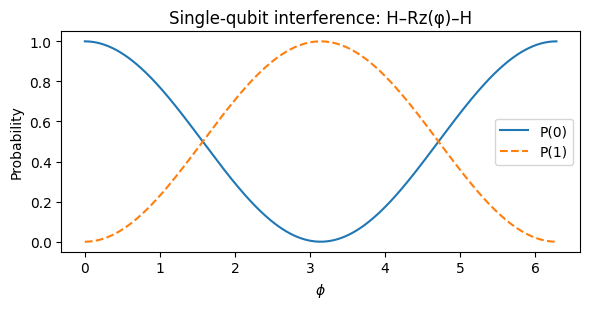

In [2]:
# 3a) Plot the interference fringe vs phase φ
phis = np.linspace(0, 2*np.pi, 361)
P0, P1 = [], []
for phi in phis:
    U = H @ Rz(phi) @ H
    out = U @ zero
    p = probs(out, n=1)
    P0.append(p[0])
    P1.append(p[1])

plt.figure(figsize=(6,3.2))
plt.plot(phis, P0, label='P(0)')
plt.plot(phis, P1, label='P(1)', linestyle='--')
plt.xlabel(r'$\phi$')
plt.ylabel('Probability')
plt.title('Single-qubit interference: H–Rz(φ)–H')
plt.legend()
plt.tight_layout()
plt.show()


## 4) Which-path information reduces visibility

Insert a **controlled-U** between the two Hadamards, acting on an ancilla initially in $$|0\rangle$$:
- If $$U=I$$: no entanglement, full visibility.
- If $$U=X$$ (i.e., perfect which-path): full entanglement, **no** interference.
- Intermediate $$U$$: partial entanglement, reduced visibility $$V=|\langle 0|U|0\rangle|.$$

We expect
$$
P(0)=\tfrac12\big(1+V\cos(\phi+\alpha)\big),\quad
\langle 0|U|0\rangle = V e^{-i\alpha}.
$$


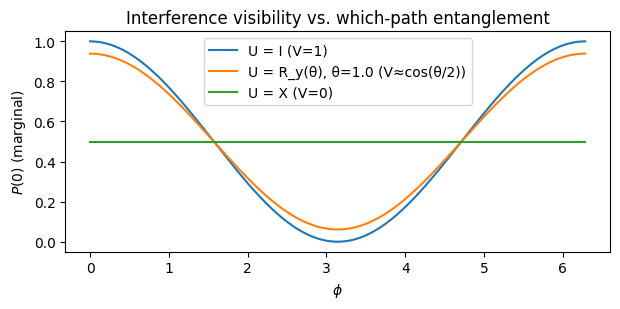

In [3]:
# 4a) Visibility demo with controlled-U
def interferometer_with_ancilla(Uanc, phis):
    P0 = []
    CU = controlled(Uanc, ctrl=0, tgt=1, n=2)   # control = path qubit
    for phi in phis:
        # |0,0> --(H on qubit 0)--> superposition --(CU)--> entangled --(Rz on qubit 0)--> phase --(H)-->
        H0    = kron(H, I2)
        Rz0   = kron(Rz(phi), I2)
        U_tot = H0 @ Rz0 @ CU @ H0
        psi0  = kron(zero, zero)
        out   = U_tot @ psi0
        p     = probs(out, n=2)
        # Marginal on first qubit = sum over ancilla outcomes
        P0.append(p[0] + p[1])   # states |00>, |01>
    return np.array(P0)

phis = np.linspace(0, 2*np.pi, 361)
curves = {
    'U = I (V=1)': I2,
    'U = R_y(θ), θ=1.0 (V≈cos(θ/2))': Ry(1.0),
    'U = X (V=0)': X
}

plt.figure(figsize=(6.3,3.2))
for lab, Uanc in curves.items():
    P0 = interferometer_with_ancilla(Uanc, phis)
    plt.plot(phis, P0, label=lab)
plt.xlabel(r'$\phi$'); plt.ylabel(r'$P(0)$ (marginal)')
plt.title('Interference visibility vs. which-path entanglement')
plt.legend()
plt.tight_layout()
plt.show()


## 5) Quantum parallelism (black-box oracle) and phase kickback

Let the oracle be
$$
U_f:\ |x\rangle|y\rangle \mapsto |x\rangle\,|y\oplus f(x)\rangle,\qquad f:\{0,1\}^n\to\{0,1\}.
$$

1. **Parallel evaluation (data superposition):**  
   Prepare $$\frac{1}{\sqrt{2^n}}\sum_x|x\rangle\otimes|0\rangle$$ and apply $$U_f$$ to obtain  
   $$\frac{1}{\sqrt{2^n}}\sum_x|x\rangle|f(x)\rangle.$$
   A single measurement returns one pair $$\big(x, f(x)\big)$$.

2. **Phase kickback (use $$|-\rangle$$ target):**  
   Prepare $$\frac{1}{\sqrt{2^n}}\sum_x|x\rangle\otimes|-\rangle$$ then
   $$
   U_f\Big(|x\rangle|-\rangle\Big)=(-1)^{f(x)}|x\rangle|-\rangle,
   $$
   so the **phase** $$(-1)^{f(x)}$$ is imprinted on the data register.  
   Interference (Hadamards) can extract global properties (e.g., Deutsch problem).


In [4]:
# 5a) Build 1-qubit Boolean oracles U_f and test phase kickback (Deutsch’s problem)
def Uf_from_truth_table(f0, f1):
    """Return 4x4 oracle for 1-bit f with f(0)=f0, f(1)=f1."""
    # Maps |x,y> -> |x, y XOR f(x)|
    U = np.zeros((4,4), dtype=complex)
    for x in (0,1):
        for y in (0,1):
            y_out = y ^ (f1 if x==1 else f0)
            in_idx  = 2*x + y
            out_idx = 2*x + y_out
            U[out_idx, in_idx] = 1
    return U

def deutsch_run(f0, f1):
    Uf = Uf_from_truth_table(f0, f1)
    # |ψ_in> = |+> ⊗ |-> = (H|0>) ⊗ (H|1>)
    psi_in = kron(plus, minus)
    psi_out = Uf @ psi_in
    # Apply H on data qubit to interfere phases
    out = kron(H, I2) @ psi_out
    p = probs(out, n=2)
    # Measure data marginal (sum over target)
    P0 = p[0] + p[1]
    P1 = p[2] + p[3]
    return P0, P1, p, out

cases = {
    "constant 0": (0,0),
    "constant 1": (1,1),
    "balanced (identity)": (0,1),
    "balanced (NOT)": (1,0),
}

print("Deutsch algorithm (measure data qubit: 0 ⇒ constant, 1 ⇒ balanced):\n")
for name,(f0,f1) in cases.items():
    P0, P1, p_full, _ = deutsch_run(f0,f1)
    print(f"{name:>18}:  P(data=0)={P0:.3f},  P(data=1)={P1:.3f}")


Deutsch algorithm (measure data qubit: 0 ⇒ constant, 1 ⇒ balanced):

        constant 0:  P(data=0)=1.000,  P(data=1)=0.000
        constant 1:  P(data=0)=1.000,  P(data=1)=0.000
balanced (identity):  P(data=0)=0.000,  P(data=1)=1.000
    balanced (NOT):  P(data=0)=0.000,  P(data=1)=1.000


## 6) Exercises (quick)

1. **Analytic fringe:** Starting from $$H\,R_z(\phi)\,H|0\rangle,$$ derive $$P(0)=\cos^2(\phi/2)$$ and verify numerically.  
2. **Visibility:** In the controlled-$$R_y(\theta)$$ demo, show that $$V=\big|\langle 0|R_y(\theta)|0\rangle\big|=\cos(\theta/2).$$  
3. **Build your own oracle:** Implement $$U_f$$ for a 2-bit input $$f:\{0,1\}^2\to\{0,1\}$$ and demonstrate phase kickback on $$|--\rangle$$ target(s).  
4. **Deutsch–Jozsa (n=2):** Prepare $$H^{\otimes 2}|00\rangle\otimes|-\rangle$$, apply your oracle, then $$H^{\otimes 2}$$ on data.  
   Show that measuring all zeros on data indicates “constant”; any other outcome indicates “balanced”.


## 7) Key takeaways

- **Superposition** allows storing many computational branches at once; **measurement** returns one branch.  
- **Interference** is how quantum algorithms amplify the right answers and cancel the wrong ones.  
- **Phase kickback** converts function values into phases, which **interfere** to reveal global properties.  
- **Entanglement with an environment (or ancilla)** leaks which-path information and **reduces visibility**.  
- Practical algorithms (Deutsch–Jozsa, Simon, Grover, QFT-based) = **parallelism + interference**.


## 8) Reflection
- **Superposition vs interference:**  
  A quantum register can spread across many possibilities, but the *power* comes from interference, where amplitudes reinforce or cancel. Without interference, parallelism alone offers no computational gain.

- **Entanglement as a double-edged sword:**  
  Coupling qubits can *enable* correlated outcomes (resource for quantum advantage), but if the coupling is to an uncontrolled system (like the environment), it *destroys* visibility by leaking “which-path” information.

- **Phase kickback insight:**  
  Oracles don’t just label function values—they imprint phases on superposed inputs. That phase is what later circuits exploit to extract global properties of \(f(x)\) efficiently.

- **Big picture:**  
  Superposition = spreading information.  
  Interference = shaping it.  
  Entanglement = deciding whether the interference is usable or washed out.  


---
### Links
- **Open in Colab (from GitHub):** replace `YOUR_GITHUB_USERNAME/qucode-21days`
  - `https://colab.research.google.com/github/YOUR_GITHUB_USERNAME/qucode-21days/blob/main/Day10_Circuits,_Compilation,_and_Transpilation.ipynb.ipynb`
- **Report an issue / suggest a fix:** link to your repo issues page
